<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/cardio_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#getting the data from PC

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cardio_train.csv to cardio_train.csv
User uploaded file "cardio_train.csv" with length 2941524 bytes


In [2]:
# Imports
import numpy as np 
import pandas as pd 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from keras.optimizers import *
from keras.initializers import *
from keras.models import *
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [3]:
data_raw=pd.read_csv("cardio_train.csv",sep=";")
data_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data_raw.drop("id",axis=1,inplace=True)

In [5]:
data_raw.drop_duplicates(inplace=True)

In [6]:
df = data_raw.copy(deep=True)

In [9]:
#Higher diastolic than systolic blood pressure is impossible, too. So let's remove these.
df.drop(df[df["ap_lo"] > df["ap_hi"]].index, inplace=True)
df.drop(df[df["ap_lo"] <= 30].index, inplace=True)
df.drop(df[df["ap_hi"] <= 40].index, inplace=True)
df.drop(df[df["ap_lo"] >= 200].index, inplace=True)
df.drop(df[df["ap_hi"] >= 250].index, inplace=True)

#A study published by doctors in NCBI NLM recorded a maximum blood pressure of 370/360 mm Hg. This study was performed by recording blood pressure in 10 male athletes through radial artery catheterization.
#Thus we can drop the ap_hi outlier values over 250 and ap_lo outlier values over 200, without fear of missing data.
out_filter = ((df["ap_hi"]>250) | (df["ap_lo"]>200) )
print("There is {} outlier".format(df[out_filter]["cardio"].count()))

df = df[~out_filter]
df.describe

There is 0 outlier


<bound method NDFrame.describe of          age  gender  height  weight  ap_hi  ...  gluc  smoke  alco  active  cardio
0      18393       2     168    62.0    110  ...     1      0     0       1       0
1      20228       1     156    85.0    140  ...     1      0     0       1       1
2      18857       1     165    64.0    130  ...     1      0     0       0       1
3      17623       2     169    82.0    150  ...     1      0     0       1       1
4      17474       1     156    56.0    100  ...     1      0     0       0       0
...      ...     ...     ...     ...    ...  ...   ...    ...   ...     ...     ...
69995  19240       2     168    76.0    120  ...     1      1     0       1       0
69996  22601       1     158   126.0    140  ...     2      0     0       1       1
69997  19066       2     183   105.0    180  ...     1      0     1       0       1
69998  22431       1     163    72.0    135  ...     2      0     0       0       1
69999  20540       1     170    72.0    12

In [10]:
X = df.drop('cardio', axis=1)
Y = df['cardio']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
s = StandardScaler()
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

# Split train set in train and validation set:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=0)

In [11]:
# Silence warnings
import warnings as w
w.simplefilter('ignore')


def create_model():
    # Hyperparameter:
    init_w = glorot_uniform(seed=0)
    loss = "binary_crossentropy"
    optimizer = Adadelta()
    
    # Defining the model:
    model = Sequential()

    model.add(Dense(50, kernel_initializer=init_w, input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate=0.1))

    model.add(Dense(25, kernel_initializer=init_w))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate=0.1))

    model.add(Dense(12, kernel_initializer=init_w))
    model.add(LeakyReLU())

    model.add(Dense(1, kernel_initializer=init_w))
    model.add(Activation("sigmoid"))
    
    model.summary()
    
    # Training
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=["accuracy"])

    return model

In [12]:
nn = create_model()
nn.fit(
    x=x_train,
    y=y_train,
    verbose=2,
    epochs=50,
    batch_size=256,
    validation_data=[x_valid, y_valid])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25)                0

ValueError: ignored

Confusion Matrix: 
 [[6160 2645]
 [4394 3964]]
AUC-score: 0.6228125430157738


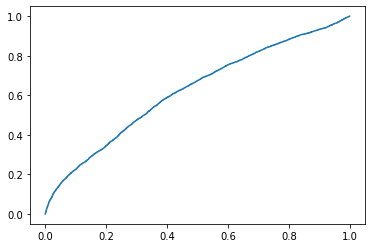

In [14]:
y_pred = nn.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())
print("Confusion Matrix:", "\n", cm)

tpr, fpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print("AUC-score:", auc_score)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(tpr, fpr)
plt.show()